Hyperparameter tuning and model validation

In [1]:
from e3fp.fingerprint.fprint import Fingerprint
from e3fp.fingerprint.db import FingerprintDatabase
from e3fp.fingerprint.metrics.array_metrics import tanimoto
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

In [2]:
logP = pickle.load(open("logp_df.p", "rb"))

In [3]:
X_sample, y_sample = resample(logP['fingerprint'], logP['logp'], n_samples=500, random_state=42)

In [4]:
X_sample_db = FingerprintDatabase(fp_type=Fingerprint, name="X_sample")
X_sample_db.add_fingerprints(X_sample.values)
X_sample_db_fold = X_sample_db.fold(1024)

In [5]:
param = {
    'n_estimators': [50, 100, 150],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_leaf_nodes': [7, 8, 9, 10]
}
                           
grid = GridSearchCV(RandomForestRegressor(), param_grid=param, cv=5, verbose=1)
grid.fit(X_sample_db_fold.array, y_sample)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 355, in fit
    raise ValueError(
ValueError: Some value(s) of y are negative which is not allowed for Poisson regression.

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/python3.9/site-packages/sklearn/model_s

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson']},
             verbose=1)

In [6]:
grid.best_params_

{'criterion': 'squared_error'}

In [7]:
X_train, X_test, y_train, y_test = train_test_split(logP['fingerprint'], logP['logp'], test_size=0.2, random_state=42)

In [8]:
X_train_db = FingerprintDatabase(fp_type=Fingerprint, name="X_train")
X_train_db.add_fingerprints(X_train.values)
X_train_db_fold = X_train_db.fold(1024)

In [9]:
clf = RandomForestRegressor(**grid.best_params_)
clf.fit(X_train_db_fold.array, y_train)

RandomForestRegressor()

In [10]:
X_test_db = FingerprintDatabase(fp_type=Fingerprint, name="X_test")
X_test_db.add_fingerprints(X_test.values)
X_test_db_fold = X_test_db.fold(1024)

y_pred = clf.predict(X_test_db_fold.array)

In [11]:
r2_score(y_pred, y_test)

0.831277495375063

In [12]:
db = FingerprintDatabase(fp_type=Fingerprint, name="logp")
db.add_fingerprints(logP.fingerprint)
db_fold = db.fold(1024)

In [13]:
logP['forest_logp'] = clf.predict(db_fold.array)

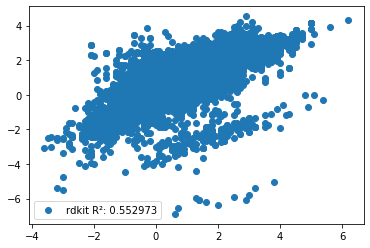

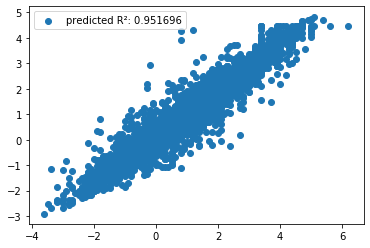

In [14]:
r2 = r2_score(logP['logp'], logP['rdkit_logp'])
pyplot.scatter(logP['logp'], logP['rdkit_logp'], label='rdkit R²: %f' % r2)
pyplot.legend()
pyplot.show()

r2 = r2_score(logP['logp'], logP['forest_logp'])
pyplot.scatter(logP['logp'], logP['forest_logp'], label='predicted R²: %f' % r2)
pyplot.legend()
pyplot.show()

Conclusion: The model performs relatively well and for this dataset is a significant improvement over the results from Rdkit's implementation of the method developed by Wildman and Crippen.

Wildman, S., Crippen, G. Prediction of Physicochemical Parameters by Atomic Contributions. J. Chem. Inf. Comput. Sci 868-873 (1999)